## INTRODUCCION

La siguiente herramienta sirve para detectar el perfil fraudulento de un flujo determinado. El Arbol de decisión seleccionará las variables de mayor ponderación en la clasificación e inidicará los parametros de corte 

ARBOL DE DECISIÓN - CLASIFICAR FLUJO FRAUDULENTO SOBRE UN SELLER -

Pasos a Seguir:

1. Definir Parametros en la 2da celda en INPUT 1: 
- Seller
- fecha inicial
- fecha final
2. En caso de que se trate de fraude no reportado, se debe tener un excel de los payments ID con el siguiente formato: se debe ingresar la ubicación del archivo
3. Correr Query -->  Ir a la barra de tareas, Run, Run All Cells.
4. Abajo se encuentra un Reporte con los highilights y más abajo el Arbol de decisión.
5. Selección de conjunto de variables en INPUT 2 --> En el script se lo encuentra con este titulo.
6. Opciónal: Exportar a excel la base --> En el script se lo encuentra con este titulo.





Tips Python:
- corre una celda: Control+Enter 
- Si en el icono de la pestaña hay un reloj de arena, es que el script está corriendo
- Te moves con las flechitas para subir y bajar
- Para salir de una celda, Esc
- Para entrar a una celda Enter
- Interrumpir el script: Ir a la barra de tareas, Kernel, shut_down kernel y despues de un minuto, restart kernel


ACLARACIÓNES

- Se trabaja sobre flujo MI 
- Se trabaja sobre flujo PAY_PM_TYPE_ID 'credit_card','debit_card'
- Se trabaja sobre flujo Config_id 'OFF','GTW','REC'
- Se trabaja sobre flujo solo flujo aprobado (A y D) 
- Tomo de base en la join a la tabla de Tera, no la de redshift
- La base de Redshift se apmplia 2 dias en los extremos porque las bases pueden tener formatos de fechas diferentes
- Valores Null se reemplazan con 0
- New user & New device se definieron como menor a 15 dias
- Se trabaja con cbks LOW y cbks MIDHIGH
- Valores Risk null que son por definicion de ST o bugs tienen un risk de 100 
- Rango de Monto es fijo: Rnago_Aprob: 1 Menor a 10, 2 menor a 50, 3 menor a 100, 4 menor a 500, 5 menor a 1000, 6 mayor a 1000
- Rango de Risk es por percentiles
- Para clasificar en un nodo, ambas partes tienen que ser mayor a 1% de la población total


In [1]:
from pftoolbox.tables import query2df
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
# from adspy_shared_utilities import plot_decision_tree
from sklearn.model_selection import train_test_split
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn import tree
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier

%run db_access.py
%run credenciales.py

ModuleNotFoundError: No module named 'pftoolbox'

# 1. Defino parametros

INPUT 1

In [12]:
Seller=input(prompt='Seller')  #Pague veloz 473887956  
desde=input(prompt='Start date')  #'2020-10-01'
hasta=input(prompt='End date')  #'2020-08-01'



Seller e
Start date e
End date e


In [7]:
#Nose porque este campo: spr.creation_date trae menos campos y tengo que extenderle los limites
desde2=((pd.to_datetime(desde))+dt.timedelta(days=-1)).strftime("%Y-%m-%d")
hasta2=((pd.to_datetime(hasta))+dt.timedelta(days=1)).strftime("%Y-%m-%d")

In [8]:
query01= """
Select
sor.sc_cust_id, --id scoring
sor.flag_notif_cbk,
sor.provider_id,
to_char(sor.creation_date ,'yyyy-mm-dd-hh') creationdate,

--X cualitativas
sor.pay_operation_type_id,
stc_profile_id,
sor.pay_pm_desc,
sor.pay_pm_type_id,
to_char(sor.risk) TeraRisk,

--X cuanti
(case when lk.CUS_CUST_STATUS='M' then 1 else 0 end) usuario_guest, --Saber si la cuenta que compro fue guest
(case when prod2.MP_PROD_USER_TYPE='guest' and sor.pcc_status in ('A','D') then 1 else 0 end) pago_guestT, --Saber si el pago fue guest
--sor.pay_ccd_installments_qty,
to_char( CASE WHEN sor.pcc_status in ('A','D') AND not (sor.pcc_status='I' AND sor.is_rej_api_risk=1)  THEN (sor.PAY_TRANSACTION_DOL_AMT+sor.pay_shipping_cost_dol_amt) ELSE 0 END ) "AprobadoPF",
to_char((cast(sor.creation_date as date format 'yyyy-mm-dd') - cast(dev.FRD_DEVICE_ML_CREATION_DATE as date format 'yyyy-mm-dd'))) diasDeviceT,
to_char((cast(sor.creation_date as date format 'yyyy-mm-dd') - cast(lk.CUS_RU_SINCE_DT as date format 'yyyy-mm-dd'))) diasUsuarioT,

--laburar a ANALIZAR
pp.pay_ccd_first_six_digits,
pp.pay_ccd_last_four_digits, 
pp.pay_ccd_cardholder_name,
sor.pcc_status,


-- Velocity. a laburar y a cuanti
--lk.CUS_ZIP_CODE,
--lk.CUS_CUST_DOC_NUMBER,
lk.CUS_EMAIL,
sor.cus_cust_id_buy,
to_char(sor.creation_date ,'yyyy-mm-dd-hh') dia,

--Otros
sor.pay_payment_id
-- shp.shp_quantity,
-- shp.shp_receiver_street_name_rsd,
-- shp.shp_receiver_zipcode_rsd,
-- shp.shp_receiver_street_number_rsd,
-- shp.SHP_ADD_STREET_NAME

from SCORING.scoring_origin_report_all sor
-- left join WHOWNER.BT_SHP_SHIPMENTS shp...  como joineo con payment?
inner join WHOWNER.BT_MP_PAY_PAYMENTS pp on pp.pay_payment_id=sor.pay_payment_id --PAGOS
inner join WHOWNER.LK_CUS_CUSTOMERS_DATA lk on sor.cus_cust_id_buy=lk.cus_cust_id --ALGO DE USUARIOS
left join WHOWNER.BT_MP_PRODUCTS prod2 on prod2.mp_prod_id=sor.mp_prod_id --saber si el pago fue guest
left join WHOWNER.LK_FRAUD_DEVICE dev on dev.pay_payment_id=sor.pay_payment_id --info del device
where 1=1
and PAY_PM_TYPE_ID  in ('credit_card','debit_card')
and sor.config_id in ('OFF','GTW','REC') 
and sor.flow_type='MI'
and sor.pcc_status not in ('I','R','C')
and sor.cus_cust_id_sel in ("""

query02=""") and sor.creation_date>=date '"""
query03="""' and sor.creation_date<=date '"""
query04="' GROUP BY 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22 --sample 15000"


query0=query01+Seller+query02+desde+query03+hasta+query04

df=query2df.teradata(query0,credenciales,TERA_access,exclude_drop=True)
dfT=df.copy()

Total:	1 query(ies)
	0 create(s)
	1 select(s)
	0 drop(s) excluded
	0 other(s)


Tiempo:	493.44 segs 

Output:	df con 18933 registros



,SC_CUST_ID,FLAG_NOTIF_CBK,PROVIDER_ID,creationdate,PAY_OPERATION_TYPE_ID,STC_PROFILE_ID,PAY_PM_DESC,PAY_PM_TYPE_ID,TeraRisk,usuario_guest,pago_guestT,AprobadoPF,diasDeviceT,diasUsuarioT,PAY_CCD_FIRST_SIX_DIGITS,PAY_CCD_LAST_FOUR_DIGITS,PAY_CCD_CARDHOLDER_NAME,PCC_STATUS,CUS_EMAIL,CUS_CUST_ID_BUY,dia,PAY_PAYMENT_ID
0,2.699249e+11,0,online_payments_ca_beta,2021-07-21-07,regular_payment,LOW,Mastercard,credit_card,0,0,1,1199.165,121,1559,544731.0,1028.0,acir f rodrigues,A,N/A,252029072.0,2021-07-21-07,1.597330e+10
1,2.689493e+11,0,online_payments_ca_beta,2021-07-10-11,regular_payment,LOW,Visa,credit_card,0.21,0,1,398.6849,-1,2166,489391.0,6140.0,Vera lucia d silva,A,N/A,189416733.0,2021-07-10-11,1.579058e+10
2,2.700684e+11,0,online_payments_ca_beta,2021-07-23-10,regular_payment,LOW,Mastercard,credit_card,0,0,1,8.7468,62,6021,545430.0,2019.0,BRUNO G SILVA,A,N/A,78366676.0,2021-07-23-10,1.601019e+10
3,2.699295e+11,0,online_payments_ca_beta,2021-07-21-08,regular_payment,LOW,Mastercard,credit_card,0,0,1,239.0473,-1,986,550209.0,5333.0,SANDRA M S DURAES,A,N/A,376237605.0,2021-07-21-08,1.597458e+10
4,2.703100e+11,0,online_payments_ca_beta,2021-07-28-09,regular_payment,LOW,Visa,credit_card,0.01,0,1,59.8975,20,4679,444456.0,9755.0,RHANIERY W MUELLER,A,N/A,56551386.0,2021-07-28-09,1.607447e+10


In [9]:
payments_T=str(tuple((df['PAY_PAYMENT_ID'].apply(lambda x: int(x)))))

In [11]:
query1= """
Select

--Context
so.pay_payment_id,
--to_char(so.creation_date,'yyyy-mm-dd') as dia,
so.risk,
so.has_approved_payment_tc, --el usuario+TC tienen un pago aprobado con más de 90 días sin cbks
so.has_approved_device_ml, --el usuario+device tienen un pago aprobado con más de 90 días sin cbks
so.has_approved_payment_document, --el usuario+device tienen un pago aprobado con más de 90 días sin cbks
so.sender_age diasUsuario,
so.device_age diasDevice,

phtc_qty_app_same_collector_30d,  --cantidad de aprobados con mismo comercio en los ultimos 30 dias
phtc_qty_same_collector_30d, --cantidad con mismo comercio en los ultimos 30 dias
phtc_qty_app_same_collector_7d,
phtc_qty_same_collector_7d,

ph_qty_app_same_collector_30d,  --cantidad de aprobados con mismo comercio en los ultimos 30 dias
ph_qty_same_collector_30d, --cantidad con mismo comercio en los ultimos 30 dias
ph_qty_app_same_collector_7d,
ph_qty_same_collector_7d,

--phtc_qty_app_same_collector_1d,
--phtc_qty_same_collector_1d,
ph_same_rec_amt_app_30d,  --monto total aprobado con mismo comercio en ultimos 30 días
ph_count_cc_90d, --cantidad de tarjetas usadas por usuario en ultimos 90 días
phtcs_app_acc_90d, --phtcs_app_acc_90d=0,en los últimos 90 días el usuario solo tiene pagos aprobados con la tarjeta que esta usando. Si fuera 1, quiere decir que ademas, tuvo pagos aprobados con otra tarjeta
ph_user_cd_90d, --cuenta la cantidad de telefonos diferentes que tuvo el usuario
ph_amt_25_app_acc_7d, --pagos aprobados del usuario mayores a 25usd en ultimos 7 dias
ph_amt_25_bf_1d, --pagos mayores a 25 que se encuentran en pending durante el ultimo día
ph_amt_25_ria_7d --cantidad de pagos mayores a 25 usd rechazados ultimos 7 días
ph_qty_app_acc_90d, --cantidad de pagos aprobados totales ultimos 90 días
ph_amt_app_acc_60d,  --monto total aprobado por usuario ultimos 60 dias
ph_amt_rec_app_acc_1d, --monto aprobado diario por día del usuario con mismo comercio!
ph_amt_rec_app_1d, --monto en cualquier estado por usuario por dia con mismo comercio... estaria buena esta logica pero en cantidad de casos, no en suma
ph_old_app_cc_30d, --la tc tiene al menos un pago aprobado pasados los 30 dias y menor a 90
ph_old_app_doc_30d, --cantidad de pagos aprobados mismo usuario/doc mayor a 30 dias menor a 90 dias
ph_amt_ain_3d, --El monto que tiene en espera para ser revisados por SS en ultimos 3 dias
ph_qty_cbk_90d, --cbks ultimos 90 dias
ph_amt_cbk_90d, --amount cbk ultimos 90
phtc_count_users_12h,
phtc_count_users_1d,
phtc_count_users_3d,
phtc_count_users_7d,
phtc_count_users_same_seller_1h,
phtc_count_users_same_seller_12h,
phtc_count_users_same_seller_1d,
phtc_count_users_same_seller_3d,
phtc_count_users_same_seller_7d,


--SOBRE EL VENDEDOR
--fcccr_card_all_qty_3h_new_device_sin_freepass, --Cuenta la cantidad de pagos que recibio en las ultimas 3hs con: nuevo celular(ultimos 7 dias) y sin ser freepass TC/Device
--fcccr_card_all_qty_1d_new_device_sin_freepass,
--fcccr_card_all_qty_10d_new_device_sin_freepass,
--fcccr_card_all_amount_3h_new_device_sin_free_pass,
--fcccr_card_all_amount_1d_new_device_sin_free_pass,
--fcccr_card_all_amount_10d_new_device_sin_free_pass,
--fcccr_card_all_amount_3h,
--fcccr_card_all_amount_1d,
--fcccr_card_all_amount_10d,
--fcccr_card_all_qty_idem_sender_3h,  --dudaaa
--fcccr_card_all_qty_idem_sender_1d,    --dudaaa
--fcccr_card_all_qty_idem_sender_10d,  --dudaaa
--fcccr_card_all_qty_3h,
--fcccr_card_all_qty_1d,
--fcccr_card_all_qty_10d,


case when pp.mp_prod_id in ('BC32A1FTRPP001U8NHFG','BF6T4TL5G6HG01KPO2LG','BD72KDPQIJ2G01BAK93G','BC32BHVTRPP001U8NHL0','BJEO9TFBF6RG01IIIOU0','BC32CANTRPP001U8NHO0','BC32BQJU643001OI397G','BJDGPHVBF6RG01IIIOSG',
'BF3L8CCEVKKG01NFMI70','BEL8E9E0CAH001G99FI0','BF3L7UNP2P4001H0L200','BT7OFH09QS3001K5A0H0','BT7OEN7EOO6G01NJK3Q0','BSOO1O89QS3001K5A0GG','BC32CCRU643001OI39AG','BCT80R50FCR001F95260','BEVP8TU8QCDG01NJH370',
'BT7OE9FEOO6G01NJK3PG','BF3L7V7P2P4001H0L21G','BT7OF5FEOO6G01NJK3QG','BC32A7VTRPP001U8NHK0','BF3L8C7P2P4001H0L220','BC329V3U643001OI3910','BFRFF6JDNCEG02A7IS1G','BJDGOQNBF6RG01IIIORG','BSOO28NEOO6G01NJK3O0',
'BJEO9NVBF6RG01IIIOTG','BF3L7UVP2P4001H0L210','BF3L7V4EVKKG01NFMI6G','BC32A7RU643001OI3940','BC32A4RU643001OI3930','BC32A7VTRPP001U8NHJ0','BC32A57TRPP001U8NHHG','BC32C7VTRPP001U8NHNG','BRP4K1BTEN2001J1IEH0',
'BC32CPFTRPP001U8NHRG','BF3JOAKEVKKG01NFMI1G','BF3L7V4EVKKG01NFMI60') then 1 else 0 end pago_guest,


--MIRA DESDE LA DIRECCION
phsa_qty_users_12h,
phsa_qty_users_1d,
phsa_qty_users_7d,
phsa_qty_users_15d,
phsa_qty_users_30d,
phsa_qty_users_90d,
phsa_qty_device_ml_12h,
phsa_qty_device_ml_1d,
phsa_qty_device_ml_7d,
phsa_qty_device_ml_15d,
phsa_qty_device_ml_30d,
phsa_qty_device_ml_90d,
phsa_z_android_1d,
phsa_z_android_7d,
phsa_z_android_30d,
phsa_tcs_app_90d,--cuenta la cantidad de tarjetas con pagos aprobados que tiene la dirección
phsa_tcs_r_hr_1d,
phsa_tcs_r_hr_7d,



--cat.quantity,
--ctx.reason,
--cat.CUST_DOC_NUMBER,
--cat.item_id, --ojo con este

qty_devices,
--smart_id,

country_a3_code,
external_hash

from  fraud.public.scoring_origin_mi so
left join fraud.scoring_mi.vector_fcc_tc tc on  so.scoring_id=tc.scoring_id
left join fraud.scoring_mi.vector_fcc_collections_receiver colr on  so.scoring_id=colr.scoring_id
left join fraud.scoring_mi.vector_fcc_shipping sh on  so.scoring_id=sh.scoring_id
left join fraud.scoring_mi.bin_card bin on so.scoring_id=bin.scoring_id
left join fraud.scoring_mi.shipping_address ship on so.scoring_id=ship.scoring_id
left join fraud.scoring.bt_mp_pay_payments pp on  pp.pay_payment_id = so.pay_payment_id
--left join fraud.scoring_mi.items_off cat on so.scoring_id=cat.scoring_id
--left join fraud.scoring_mi.context ctx on ctx.scoring_id=so.scoring_id


--left join scoring.scoring_provider_result spr on so.scoring_id=spr.scoring_id and so.provider_id = spr.scoring_provider
--left join scoring.scoring_tree_version st on st.scoring_id = spr.external_id and so.site_id = st.site_id
--left join scoring.hypothesis_tree_node htn on htn.tree_id = st.tree_id and htn.tree_version_id = st.tree_version_id and htn.site_id = st.site_id and htn.node_position = trunc(so.last_node/2)
left join fraud.scoring_mi.vector_fcc_user vu on vu.scoring_id=so.scoring_id
left join fraud.scoring_mi.smart_id si on si.scoring_id=so.scoring_id  --qty_devices

where 1=1
and so.pcc_status in ('A','D')
and so.receiver_id in ("""

query2=""") and so.creation_date>=date '"""
query3="""' and so.creation_date<=date '"""
query4="'"

query=query1+Seller+query2+desde2+query3+hasta2+query4

df2=query2df.redshift(query,credenciales,RS_access,exclude_drop=True)
# dfIn=query2df.teradata(query,credenciales,TERA_access,exclude_drop=True)
dfR=df2.copy()

Total:	1 query(ies)
	0 create(s)
	1 select(s)
	0 drop(s) excluded
	0 other(s)


Tiempo:	92.84 segs 

Output:	df con 18251 registros



,pay_payment_id,risk,has_approved_payment_tc,has_approved_device_ml,has_approved_payment_document,diasusuario,diasdevice,phtc_qty_app_same_collector_30d,phtc_qty_same_collector_30d,phtc_qty_app_same_collector_7d,phtc_qty_same_collector_7d,ph_qty_app_same_collector_30d,ph_qty_same_collector_30d,ph_qty_app_same_collector_7d,ph_qty_same_collector_7d,ph_same_rec_amt_app_30d,ph_count_cc_90d,phtcs_app_acc_90d,ph_user_cd_90d,ph_amt_25_app_acc_7d,ph_amt_25_bf_1d,ph_qty_app_acc_90d,ph_amt_app_acc_60d,ph_amt_rec_app_acc_1d,ph_amt_rec_app_1d,ph_old_app_cc_30d,ph_old_app_doc_30d,ph_amt_ain_3d,ph_qty_cbk_90d,ph_amt_cbk_90d,phtc_count_users_12h,phtc_count_users_1d,phtc_count_users_3d,phtc_count_users_7d,phtc_count_users_same_seller_1h,phtc_count_users_same_seller_12h,phtc_count_users_same_seller_1d,phtc_count_users_same_seller_3d,phtc_count_users_same_seller_7d,pago_guest,phsa_qty_users_12h,phsa_qty_users_1d,phsa_qty_users_7d,phsa_qty_users_15d,phsa_qty_users_30d,phsa_qty_users_90d,phsa_qty_device_ml_12h,phsa_qty_device_ml_1d,phsa_qty_device_ml_7d,phsa_qty_device_ml_15d,phsa_qty_device_ml_30d,phsa_qty_device_ml_90d,phsa_z_android_1d,phsa_z_android_7d,phsa_z_android_30d,phsa_tcs_app_90d,phsa_tcs_r_hr_1d,phsa_tcs_r_hr_7d,qty_devices,country_a3_code,external_hash
0,1.559419e+10,0.0060754031874239449,Y,N,Y,1823.179074,34.597604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,None,0.0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1.0,BRA,None
1,1.559432e+10,0.015414327383041382,N,N,Y,132.298692,0.175034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,None,0.0,None,0.0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,100.0,BRA,None
2,1.559551e+10,0.01567079685628414,N,N,Y,4774.544953,0.181828,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,None,0.0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1.0,BRA,None
3,1.559907e+10,0.07495100796222687,N,N,N,4011.050046,0.672500,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,None,0.0,None,0.0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,100.0,BRA,None
4,1.560535e+10,0.008380704559385777,N,N,N,2218.381793,49.025520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,None,0.0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,23.0,BRA,None


In [17]:
#Joineo redshift con tera
dfT['PAY_PAYMENT_ID']=dfT['PAY_PAYMENT_ID'].apply(lambda x: round(x))
df01=pd.merge(dfT,dfR, left_on='PAY_PAYMENT_ID',right_on='pay_payment_id', how='left')

In [18]:
V_Null=pd.DataFrame(df01.count())
V_Null['qty_Null']=df01.isnull().sum()
V_Null['qty_tot']=df01.count().max()
V_Null['%V_Null']=(V_Null['qty_Null']/V_Null['qty_tot']).apply(lambda x: round(x*100,1))
List_features_null=V_Null.sort_values(by='qty_Null',ascending=False).head(15)
List_features_null
# Y si a las variables que tienen más de 10% de valores null, le aplico dummyes con -1, significando dummies?

,0,qty_Null,qty_tot,%V_Null
external_hash,0,18934,18934,100.0
phsa_qty_device_ml_7d,0,18934,18934,100.0
ph_user_cd_90d,0,18934,18934,100.0
ph_amt_25_bf_1d,0,18934,18934,100.0
ph_amt_app_acc_60d,0,18934,18934,100.0
phsa_qty_users_12h,0,18934,18934,100.0
phsa_qty_users_1d,0,18934,18934,100.0
phsa_qty_users_7d,0,18934,18934,100.0
phsa_qty_users_30d,0,18934,18934,100.0
phsa_qty_users_90d,0,18934,18934,100.0


In [19]:
Pfaltantes=df01['pay_payment_id'].isnull().sum()/df01['PAY_PAYMENT_ID'].count() #CANTIDAD DE PAYMENTS DE TERA QUE NO SE ENCONTRARON EN REDSHIFT
texto1='Del 100 % de los payments_id de Tera, no se encontraron '+str(round(Pfaltantes*100,1))+'% en redshift (Existen '+str(dfT['PAY_PAYMENT_ID'].count()) +' pagos en Tera)'


In [21]:
df01['has_approved_payment_tc_0']=0
df01['has_approved_device_ml_0']=0
df01['has_approved_payment_document_0']=0

# df01.reset_index(inplace = True)
IndexHA = df01[df01['has_approved_payment_tc']=='Y'].index #Devuelve los index de los valores que estan en Lista
df01.loc[IndexHA,'has_approved_payment_tc_0'] = 1 #Reemplaza los valores de'Others' por valor en Col Ruta en los index definidos 

IndexHA = df01[df01['has_approved_device_ml']=='Y'].index #Devuelve los index de los valores que estan en Lista
df01.loc[IndexHA,'has_approved_device_ml_0'] = 1 #Reemplaza los valores de'Others' por valor en Col Ruta en los index definidos 

ndexHA = df01[df01['has_approved_payment_document']=='Y'].index #Devuelve los index de los valores que estan en Lista
df01.loc[IndexHA,'has_approved_payment_document'] = 1 #Reemplaza los valores de'Others' por valor en Col Ruta en los index definidos 



 

In [22]:
df01['diasUsuarioT']=df01['diasUsuarioT'].fillna(0)
df01['diasUsuarioT']=df01['diasUsuarioT'].apply(lambda x: int(x))
df01['diasDeviceT']=df01['diasDeviceT'].fillna(0)
df01['diasDeviceT']=df01['diasDeviceT'].apply(lambda x: int(x))

In [23]:
df01['New_user']=0
df01['New_device']=0

Index1 = df01.where(df01['diasUsuarioT']<15).index #Devuelve los index de los valores que estan en Lista
df01.loc[Index1,'New_user'] = 1 #Reemplaza los valores de'Others' por valor en Col Ruta en los index definidos 

Index2 = df01[df01['diasDeviceT']<15].index #Devuelve los index de los valores que estan en Lista
df01.loc[Index2,'New_device'] = 1 #Reemplaza los valores de'Others' por valor en Col Ruta en los index definidos

In [24]:
df01['AprobadoPF']=df01['AprobadoPF'].apply(lambda x: float(x))


In [25]:
# 10,50,100,500,1000, mayor a 1000
df01['Rango_Aprob']=6

Index10 = df01[df01['AprobadoPF']<=1000].index #Devuelve los index de los valores que estan en Lista
df01.loc[Index10,'Rango_Aprob'] = 5 #Reemplaza los valores de'Others' por valor en Col Ruta en los index definidos

Index11 = df01[df01['AprobadoPF']<=500].index #Devuelve los index de los valores que estan en Lista
df01.loc[Index11,'Rango_Aprob'] = 4 #Reemplaza los valores de'Others' por valor en Col Ruta en los index definidos

Index12 = df01[df01['AprobadoPF']<=100].index #Devuelve los index de los valores que estan en Lista
df01.loc[Index12,'Rango_Aprob'] = 3 #Reemplaza los valores de'Others' por valor en Col Ruta en los index definidos

Index13= df01[df01['AprobadoPF']<=50].index #Devuelve los index de los valores que estan en Lista
df01.loc[Index13,'Rango_Aprob'] = 2 #Reemplaza los valores de'Others' por valor en Col Ruta en los index definidos

Index14 = df01[df01['AprobadoPF']<=10].index #Devuelve los index de los valores que estan en Lista
df01.loc[Index14,'Rango_Aprob'] = 1 #Reemplaza los valores de'Others' por valor en Col Ruta en los index definidos

In [26]:
v1=df01['has_approved_device_ml'].isnull().sum()/df01['has_approved_device_ml'].count()
#DEVUELVE UN NUMERO DE 0 A 1 DE CUANTO DEL TOTAL DE LOS PAGOS NO TRAEN DEVICE 
texto2='Del 100 % de los pagos,'+str(round(v1*100,1))+'% no trajo device'

v13=df01['qty_devices'].isnull().sum()/df01['qty_devices'].count()
#DEVUELVE UN NUMERO DE 0 A 1 DE CUANTO DEL TOTAL DE LOS PAGOS NO TRAEN DEVICE 
texto8='Del 100 % de los pagos,'+str(round(v13*100,1))+'% no trajo qty_device'

In [27]:
v2=df01['external_hash'].isnull().sum()/df01['external_hash'].count()
#DEVUELVE UN NUMERO DE 0 A 1 DE CUANTO DEL TOTAL DE LOS PAGOS NO TRAEN DEVICE 
texto3='Del 100 % de los pagos,'+str(round(v2*100,2))+'% no trajo dirección'

<ipython-input-27-b4f7849efbac>:1: RuntimeWarning: divide by zero encountered in longlong_scalars
  v2=df01['external_hash'].isnull().sum()/df01['external_hash'].count()


In [28]:
texto4=str(int(df01['FLAG_NOTIF_CBK'][(df01['FLAG_NOTIF_CBK']==1)&(df01['STC_PROFILE_ID']=='MIDHIGH')].sum()))+' son MIDHIGH que se estan considerando'
#ESTOS HAY QUE ELIMINARLOS DEL ANALISIS!! SON CBK QUE VINIERON POR MIDHIGH

In [29]:
#Modifico formatos

df01['dia']=pd.to_datetime(df01['creationdate'])
df01['dia1']=df01['dia'].apply(lambda x: dt.date.strftime(x,'%d'))
df01['hora']=df01['dia'].apply(lambda x: dt.date.strftime(x,'%H'))
df01['AprobadoPF']=df01['AprobadoPF'].apply(lambda x: float(x))

df01.reset_index(inplace = True)
df01['risk2']=df01['risk']
IndexRisk = df01[df01['risk']==''].index #Son los pagos con perfil MIDINH y HIGH en strong rules que no pasaron por el modelo. No debería haber ninguno aprobado
df01.loc[IndexRisk,'risk2'] = '100' #Reemplaza los valores de'Others' por valor en Col Ruta en los index definidos 
# df01['risk2'].fillna(0)


df01['CUS_CUST_ID_BUY']=df01['CUS_CUST_ID_BUY'].apply(lambda x: float(x))

df01['PAY_CCD_FIRST_SIX_DIGITS']=df01['PAY_CCD_FIRST_SIX_DIGITS'].apply(lambda x: str(x))  #PAY_CCD_LAST_FOUR_DIGITS   

# CUS_CUST_ID_BUY
df01['PAY_CCD_LAST_FOUR_DIGITS']=df01['PAY_CCD_LAST_FOUR_DIGITS'].apply(lambda x: str(x))
df01['Num_Tarejta']=df01['PAY_CCD_FIRST_SIX_DIGITS']+df01['PAY_CCD_LAST_FOUR_DIGITS']

In [30]:
texto5='Existen '+str(df01['risk2'].isnull().sum())+' valores Null en Risk'

df01['risk2']=df01['risk2'].fillna(0)
df01['risk2']=df01['risk2'].apply(lambda x: float(x))


In [31]:
rangeR=[]

for j in range (1,6):
    rangeR.append(np.percentile(df01['risk2'],10*j))

In [32]:
df01['class_risk']=0
w=0
for p in range(0,5):
    w=w+1
    if p==0:
        Index = df01[(df01['risk2']<=rangeR[p])].index 
        df01.loc[Index,'class_risk'] =w
    elif p==10:
        Index = df01[(df01['risk2']>rangeR[p-1])].index 
        df01.loc[Index,'class_risk'] = w 
    else:
        Index = df01[(df01['risk2']<=rangeR[p])&(df01['risk2']>rangeR[p-1])].index 
        df01.loc[Index,'class_risk'] =w

In [33]:
# class_risk=0, es menor a rangeR[0], class_risk=1, es menor a rangeR[1] y mayor a rangeR[0] 
# rangeR[0]

In [34]:
# fig, (ax1, ax2) = plt.subplots(2, sharex=True,figsize=[10,10])


pivot_0=df01.pivot_table(index=['PROVIDER_ID'],values=['AprobadoPF'],aggfunc=np.size) #para ver cantidad, cambiar sum por         
# ax1.pie(pivot_0['AprobadoPF'],labels=pivot_0.index,autopct='%.2f',center=(1,2))


pivot_1=df01[df01['FLAG_NOTIF_CBK']==1].pivot_table(index=['PROVIDER_ID'],values=['AprobadoPF'],aggfunc=np.size) #para ver cantidad, cambiar sum por         
# ax2.pie(pivot_1['AprobadoPF'],labels=pivot_1.index,autopct='%.2f',center=(1,2))

# plt.show()
# print('Primer torta providers totales que aprobaron, 2da torta providers de los cbks')

In [35]:
 # Aplico dummies a las tablas de Tera
    
df02 = pd.get_dummies(df01.loc[:,['PAY_PM_TYPE_ID','PAY_OPERATION_TYPE_ID','country_a3_code']]) #,'PAY_PM_DESC'
df1=pd.merge(df01,df02, on=df01.index, how='left')


In [36]:
# # Aplico dummy a variables grandes 1

df1=df1.iloc[:,1:] # Saco el key
df08 = pd.get_dummies(df01.loc[:,['PAY_CCD_FIRST_SIX_DIGITS']]) #'PAY_PM_TYPE_ID','PAY_PM_DESC','PAY_OPERATION_TYPE_ID','STC_PROFILE_ID','country_a3_code'

bins=pd.DataFrame(df08.sum().sort_values(ascending=False))
bins=bins[bins[0]>10].index #binesque acumulen al menos 10 compras
Tbins=df08[bins]
Tbins

df1=pd.merge(df1,Tbins, on=df1.index, how='left')

In [37]:
# # Aplico dummy a variables grandes 1

df1.drop(['key_0'],axis=1, inplace=True)
df23=df1.iloc[:,1:] # Saco el key
df09 = pd.get_dummies(df01.loc[:,['external_hash']]) #'PAY_PM_TYPE_ID','PAY_PM_DESC','PAY_OPERATION_TYPE_ID','STC_PROFILE_ID','country_a3_code'

extH=pd.DataFrame(df09.sum().sort_values(ascending=False))
extH=extH[extH[0]>5].index #binesque acumulen al menos 10 compras
TextH=df09[extH]
TextH

df1=pd.merge(df1,TextH, on=df1.index, how='left')

In [38]:
# # Aplico dummy a variables grandes 2
try:
    df1=df1.iloc[:,1:]
    df07 = pd.get_dummies(df01.loc[:,['Num_Tarejta']]) #'PAY_PM_TYPE_ID','PAY_PM_DESC','PAY_OPERATION_TYPE_ID','STC_PROFILE_ID','country_a3_code'

    Tarj=pd.DataFrame(df07.sum().sort_values(ascending=False))
    Tarj=Tarj[Tarj[0]>10].index #binesque acumulen al menos 10 compras
    TarjT=df07[Tarj]
    TarjT

    df1=pd.merge(df1,TarjT, on=df1.index, how='left')
except:
    pass

In [39]:
df1['FLAG_NOTIF_CBK'].sum()
texto6='En la base hay '+str(int(df1['FLAG_NOTIF_CBK'].sum()))+ ' cbks'

In [40]:
antcbk=int(df1['FLAG_NOTIF_CBK'].sum())
df1['FLAG_NOTIF_CBK'].sum()

684

In [41]:
# #NECESARIO CUANDO NOS INFORMAN CBKS Y NO ESTAN MARCADOS. #2 columnas: payments_id y una columna de 1, los pagos fraudes
# try:
#     path='C:/Users/mgaona/Desktop/Analisis/base python/cbks_707259310_Feb.xlsx'
#     p_fraude=pd.read_excel(path) #puede ser read_csv
#     p_fraude= pd.DataFrame(p_fraude)
#     # p_fraude['PAY_PAYMENT_ID']=p_fraude['PAY_PAYMENT_ID'].apply(lambda x: round(x))
#     # p_fraude['payment']=p_fraude['payment'].apply(lambda x: float(x))

#     df1=pd.merge(df1,p_fraude, left_on='PAY_PAYMENT_ID',right_on='PAY_PAYMENT_ID', how='left') 

#     # df1.reset_index(inplace = True)
#     IndexR = df1[df1['cbks_']==1].index #Devuelve los index de los valores que estan en Lista
#     # df1['FLAG_NOTIF_CBK']='Others' #DEFINE COLUMN
#     df1.loc[IndexR,'FLAG_NOTIF_CBK'] = df1.loc[IndexR,'cbks_'] #Reemplaza los valores de'Others' por valor en Col Ruta en los index definidos 
# except:
#     pass

In [42]:
df1['FLAG_NOTIF_CBK'].sum()

684

In [43]:
despcbk=int(df1['FLAG_NOTIF_CBK'].sum())
difcb=despcbk-antcbk
texto9=''
if difcb>0:
    texto9='Los pagos fraudes no reportados aún agregados de forma manual son:'+str(difcb)

In [44]:
df11=df1

In [45]:
# df11=df11[df11['risk2']>0.1]

In [46]:
#Cantidad de pagos sin información. util cuando no hay variables grandes

# df11.isnull().sum()

In [47]:
df11=df11.fillna(0)  # supongo que todo es 0 donde no hay información

In [48]:
df3=df11

# Reporte

In [49]:
print('ALGUNOS RESULTADOS')
print('- ',texto6, 'de los cuales',texto4)
print('- ',texto1)
print('- ',texto8)
print('- ',texto2)
print('- ',texto5,'por ser rechazados en ST')
# print('- ','las features de mayor peso:',GVar7)
print('-',texto9)
print('-  Gráfico torta muestra distribución de provider/tree que procesaron los cbks:')
# plt.pie(pivot_1['AprobadoPF'],labels=pivot_1.index,autopct='%.2f',center=(1,2))

plt.show()

# index2=index2.drop('fcccr_card_all_qty_idem_sender_3h')


ALGUNOS RESULTADOS
-  En la base hay 684 cbks de los cuales 50 son MIDHIGH que se estan considerando
-  Del 100 % de los payments_id de Tera, no se encontraron 6.0% en redshift (Existen 18933 pagos en Tera)
-  Del 100 % de los pagos,9.3% no trajo qty_device
-  Del 100 % de los pagos,6.4% no trajo device
-  Existen 1176 valores Null en Risk por ser rechazados en ST
- 
-  Gráfico torta muestra distribución de provider/tree que procesaron los cbks:


In [50]:
GVar0=(['AprobadoPF','risk2'])
# GVar0

In [51]:
GVar1=(['has_approved_payment_tc_0','has_approved_device_ml_0','has_approved_payment_document_0','New_user','New_device','pago_guest']) #'dia1','usuario_guest', 'pago_guest','Rango_Aprob' 'diasUsuario','class_risk'
# GVar1
 #'dia1','usuario_guest', 'pago_guest','diasDevice','AprobadoPF' 'diasUsuario','class_risk'

In [52]:
#Encarar por corte de red y principales variables
GVar2=(['has_approved_payment_tc_0','has_approved_device_ml_0','has_approved_payment_document_0','New_user','New_device','pago_guest','Rango_Aprob','class_risk']) #'dia1','usuario_guest', 'pago_guest','Rango_Aprob' 'diasUsuario','class_risk'
# GVar2
 #'dia1','usuario_guest', 'pago_guest','diasDevice','AprobadoPF' 'diasUsuario','class_risk'

In [53]:
#Encarar por corte de red y principales variables
GVar3=(['has_approved_payment_tc_0','has_approved_device_ml_0','has_approved_payment_document_0','New_user','New_device','pago_guest','AprobadoPF','risk2']) #'dia1','usuario_guest', 'pago_guest','Rango_Aprob' 'diasUsuario','class_risk'
# GVar3
 #'dia1','usuario_guest', 'pago_guest','diasDevice','AprobadoPF' 'diasUsuario','class_risk'

In [54]:
#Encarar con las demás variables de redshift

GVar4=df02.columns  #Todas las columnas de dummyes. para sacar, sacar de la creación de dummies
# index1=index1.union(TarjT.columns) #Todas las columnas de redshift. Tengo que sacar las que son cualitativas, ponerlas al final de la query
# index1=index1.union(Tbins.columns) #Todas las columnas de redshift. Tengo que sacar las que son cualitativas, ponerlas al final de la query
GVar4=GVar4.union(['has_approved_payment_tc_0','has_approved_device_ml_0','New_device','New_user','pago_guest']) #'dia1',, 'pago_guest','diasDevice','Rango_Aprob' 'diasUsuario','class_risk'
GVar4=GVar4.union(dfR.columns) #Todas las columnas de redshift q no son dummies. Tengo que sacar: 'pay_payment_id', 'dia' y las dummies de redshift:'country_a3_code','external_hash'
GVar4=GVar4.drop(['diasusuario','diasdevice','pay_payment_id' ,'country_a3_code', 'external_hash','has_approved_payment_tc','has_approved_device_ml','has_approved_payment_document','country_a3_code','external_hash','risk'])
# GVar4
# GVar4=GVar4.drop('qty_devices')
# GVar4=GVar4.drop('ph_amt_rec_app_acc_1d')
# GVar4=GVar4.drop('ph_amt_ain_3d')
# index1=index1.drop('ph_amt_ain_3d')

# GVar4

In [55]:
#Encarar con las demás variables de redshift

GVar5=df02.columns  #Todas las columnas de dummyes. para sacar, sacar de la creación de dummies
# index1=index1.union(TarjT.columns) #Todas las columnas de redshift. Tengo que sacar las que son cualitativas, ponerlas al final de la query
# index1=index1.union(Tbins.columns) #Todas las columnas de redshift. Tengo que sacar las que son cualitativas, ponerlas al final de la query
GVar5=GVar5.union(['has_approved_payment_tc_0','has_approved_device_ml_0','New_device','New_user','pago_guest','Rango_Aprob']) #'dia1',, 'pago_guest','diasDevice','Rango_Aprob' 'diasUsuario','class_risk'
GVar5=GVar5.union(dfR.columns) #Todas las columnas de redshift q no son dummies. Tengo que sacar: 'pay_payment_id', 'dia' y las dummies de redshift:'country_a3_code','external_hash'
GVar5=GVar5.drop(['diasusuario','diasdevice','pay_payment_id' ,'country_a3_code', 'external_hash','has_approved_payment_tc','has_approved_device_ml','has_approved_payment_document','country_a3_code','external_hash','risk'])
# GVar5
# GVar5=GVar5.drop('ph_amt_rec_app_1d')
# GVar5=GVar5.drop('ph_amt_rec_app_acc_1d')
# GVar5=GVar5.drop('ph_amt_ain_3d')
# index1=index1.drop('ph_amt_ain_3d')

# GVar5

In [56]:
GVar6=GVar4.union(Tbins.columns) #Todas las columnas de redshift. Tengo que sacar las que son cualitativas, ponerlas al final de la query

# index2=index2.drop('fcccr_card_all_qty_idem_sender_1d') 
# index2=index2.drop('fcccr_card_all_qty_idem_sender_10d') 

In [57]:
X1=df3.loc[:,GVar6] #Index0 es corte de red
y1 = df3['FLAG_NOTIF_CBK']

rf = RandomForestClassifier(random_state=0).fit(X1, y1)
names1 = list(X1.columns.values)

fi = pd.DataFrame({'feature':names1,'importance': rf.feature_importances_}).sort_values('importance', ascending = False).reset_index()
GVar7=[]
for u in range(0,10):
    GVar7.append(fi['feature'][u])
GVar7

['qty_devices',
 'PAY_CCD_FIRST_SIX_DIGITS_415274.0',
 'ph_old_app_doc_30d',
 'ph_old_app_cc_30d',
 'PAY_CCD_FIRST_SIX_DIGITS_412177.0',
 'ph_count_cc_90d',
 'PAY_CCD_FIRST_SIX_DIGITS_512267.0',
 'New_device',
 'has_approved_payment_tc_0',
 'phtcs_app_acc_90d']


# Seleccion de grupo de variables
Algunas variables agregan ruido en vez de mejorar la clasificación, por eso hay que testear con conjunto de variables. a continuación 7 opciones:


- GVar0: Solo Risk y Monto sin categorizar (Arma cortes de red)
- GVar1: FrepassTC, FreepassDevice, pago guest, new user, new device
- GVar2: FrepassTC, FreepassDevice, pago guest, new user, new device + Risk categorizado, Monto Categorizado,
- GVar3: FrepassTC, freepassDevice, pago guest, new user, new device + Risk y Monto sin categorizar
- GVar4: frepassTC, freepassDevice, pago guest, new user, new device + All redshift sin risk ni monto 
- GVar5: frepassTC, freepassDevice, pago guest, new user, new device + All redshift + sin risk y con monto categorizado
- GVar6: frepassTC, freepassDevice, pago guest, new user, new device + All redshift + Bines
- Gvar7: Las 10 features que Random Forest identificó como las de mayor peso para clasificar

Una vez que se eligió un grupo en las celdas de abajo en GrupoVar, se corre las celdas hasta que se vea el arbol

In [58]:
# En caso de que haya una variable que agrege ruido en algun grupo de variables, se la puede eliminar de la siguiente forma:
# GVar5=GVar5.drop('qty_devices')

In [59]:
GVar8=(Tbins.columns) #mayor a 1000 usd, qty_device mayor a 5, mayor al risk 0.012

INPUT 2

In [100]:
GrupoVAR=GVar7

#Aca hay que poner GrupoVAR=GVar6, GrupoVAR=GVar3, GrupoVAR=GVar0 etc.
# GrupoVAR=GrupoVAR.drop('PAY_PM_TYPE_ID_credit_card')
# GrupoVAR=GrupoVAR.drop('PAY_PM_TYPE_ID_debit_card')


Rnago_Aprob: 1 Menor a 10, 2 menor a 50, 3 menor a 100, 4 menor a 500, 5 menor a 1000, 6 mayor a 1000 


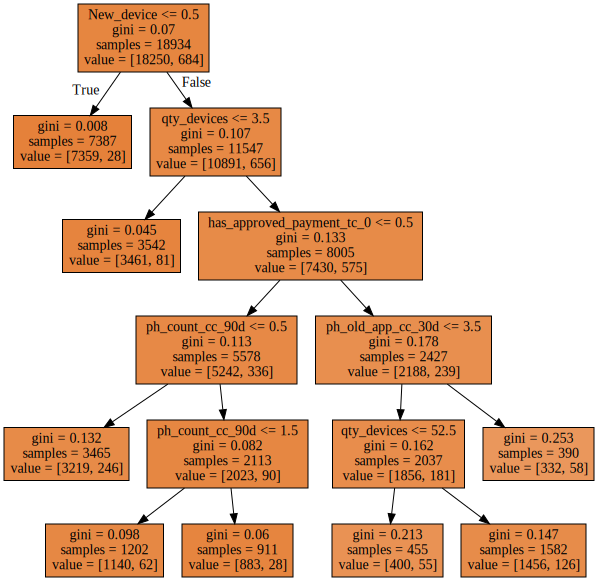

In [101]:
ramif=8
Pmin=0.02
X=df3.loc[:,GrupoVAR] #Index0 es corte de red
y = df3['FLAG_NOTIF_CBK']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
clf = DecisionTreeClassifier(min_samples_leaf=int(y.count()*Pmin),random_state = 0, max_leaf_nodes=ramif).fit(X, y) # max_leaf_nodes=ramif max_depth = ramif. Esta funca!! Solo se enfoca en lo q me interesa, max_leaf_nodes=ramif

import graphviz
%matplotlib inline
names = list(X.columns.values)
# DOT data
dot_data = tree.export_graphviz(clf, out_file=None, 
                                filled=True, feature_names=names) 
# features como X.columns?
# Draw graph
graph = graphviz.Source(dot_data, format="png") 
print('Rnago_Aprob: 1 Menor a 10, 2 menor a 50, 3 menor a 100, 4 menor a 500, 5 menor a 1000, 6 mayor a 1000 ')
graph

# sin free pass tc/device y mayor a 570 usd y despues ph same_rec_amt_app_30d menor a 2000 usd

# phtc_qty_same_collector
# has_free_pass_tc, 
#
# ph_amt_rec_app_acc_1d

# de los 84 pagos que ellos identificaron como frauder, se capturan 19+31
# has_approved_device_ml, pago_guest
# mayor a 1000 usd,sin freepasstc pago guest, sin freepass ml. bin 405071
# aprob+qty device mayor igual a 2

# phtcs_app_acc_90d+freepasstc.
# 589562
# phtcs_app_acc_90d=0,en los últimos 90 días el usuario solo tiene pagos aprobados con la tarjeta que esta usando. Si fuera 1, quiere decir que ademas, tuvo pagos aprobados con otra tarjeta
# phsa_tcs_app_90d menor a 8.. entender mejor esto
# phsa_qty_device_ml_90d=0. cantidad de devices asociados a la misma dirección (entidad vector shipping)
# ph_old_app_doc_30d=0 and freepasstc+new device, entidd
# Mayor a 130 usd, mayor a 0.018, new device y sin freepasstc new device+ sin FPTC
#new device + qty_devices>3, con FPTC mato + sin FPTC

REGRESION TREE - Separa por TPV con caracteristicas similares

In [94]:
df3['cbk_amount']=0

ndexcbk = df3[df3['FLAG_NOTIF_CBK']==1].index #Devuelve los index de los valores que estan en Lista
df3.loc[ndexcbk,'cbk_amount'] = df3['AprobadoPF'] #Reemplaza los valores de'Others' por valor en Col Ruta en los index definidos 

Rnago_Aprob: 1 Menor a 10, 2 menor a 50, 3 menor a 100, 4 menor a 500, 5 menor a 1000, 6 mayor a 1000 


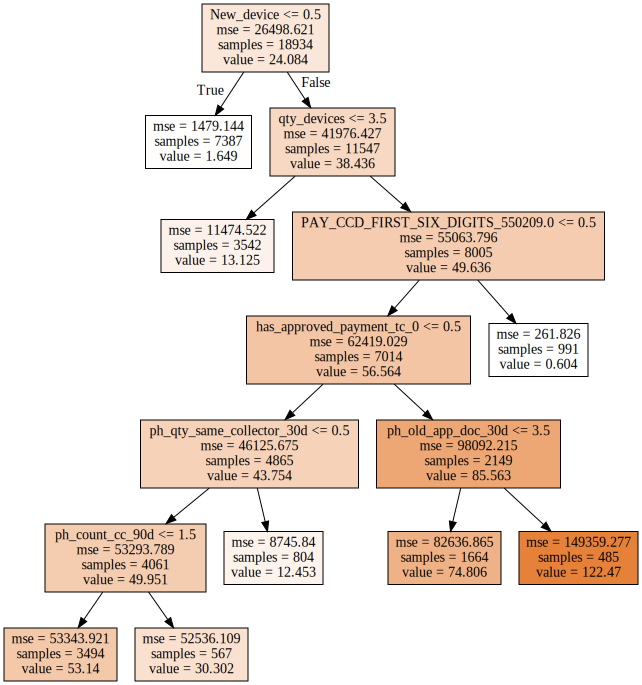

In [95]:
from sklearn.tree import DecisionTreeRegressor

y2 = df3['cbk_amount']
clf2 = DecisionTreeRegressor(min_samples_leaf=int(y.count()*Pmin),random_state = 0, max_leaf_nodes=ramif).fit(X, y2) # max_leaf_nodes=ramif max_depth = ramif. Esta funca!! Solo se enfoca en lo q me interesa, max_leaf_nodes=ramif
#criterion='mae'

import graphviz
%matplotlib inline
names = list(X.columns.values)
# DOT data
dot_data = tree.export_graphviz(clf2, out_file=None, 
                                filled=True, feature_names=names) 
# features como X.columns?
# Draw graph
graph = graphviz.Source(dot_data, format="png") 
print('Rnago_Aprob: 1 Menor a 10, 2 menor a 50, 3 menor a 100, 4 menor a 500, 5 menor a 1000, 6 mayor a 1000 ')
graph

# mse da una idea que tan lejos quedan los pagos del grupo... es decir, cuanto se parecen entre ellos

# ph_amt_ain_3d mayor a 115..?

In [64]:
# dfR['phsa_qty_device_ml_90d']

In [65]:
List_features_null['%V_Null']
#Expresa en porcentaje por orden las variables que más valores null tienen

external_hash             100.0
phsa_qty_device_ml_7d     100.0
ph_user_cd_90d            100.0
ph_amt_25_bf_1d           100.0
ph_amt_app_acc_60d        100.0
phsa_qty_users_12h        100.0
phsa_qty_users_1d         100.0
phsa_qty_users_7d         100.0
phsa_qty_users_30d        100.0
phsa_qty_users_90d        100.0
phsa_qty_device_ml_12h    100.0
phsa_qty_device_ml_1d     100.0
phsa_qty_users_15d        100.0
phsa_qty_device_ml_30d    100.0
phsa_qty_device_ml_90d    100.0
Name: %V_Null, dtype: float64

# REVISION DE ENTIDADES PRENDIDAS

In [66]:
# ScoringCbks=list(d01['SC_CUST_ID'][d01['FLAG_NOTIF_CBK']])

# from pftoolbox.helpers import tasks,api

# # scoring_ids_lst = [142709042408,135077811425,135124354587,141020566266,134631119645,134634366686,
# #                    133911582680,134631094247,134628460299,142709042408,135077811425,135124354587]

# response = tasks.check_entities(ScoringCbks,entity='all')
# response

# REVISION EN SNAPSHOT

In [67]:
# from pftoolbox.fraud import snapshot

# snp = snapshot.get([243060535929],'sco',save_file=False)

# for pay in snp.keys():
#     for sco in snp[pay].keys():
# #         print(pay,snp[pay][sco]['customers'][['site_id']].iloc[0].values)
#         print(pay,snp[pay][sco]['customers'].values)


# Exportar base a Excel

INPUT 3 (Opcional, sacar de comentario al texto exportar y correrlo. antes hay que configurar a donde se lo quiere enviar)

In [68]:
# # #EXPORTAR

# import os
# from pandas import ExcelWriter
# from openpyxl import load_workbook


# #Creo archivo
# ruta3 = "C:/Users/mgaona/Desktop/Analisis/BajadePython11.xlsx" 

# #Ingreso las bases a hojas al archivo
# dfR.to_excel(ruta3, index=False)

# # Cuando exporte, agregar las queries utilizadas

